In [2]:
import numpy as np
import pandas as pd
import matplotlib as mp
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/qmdismnp/Schulich_DS_MBAN/refs/heads/main/dataset.csv?')

Data prepocessing

In [4]:
# Handle missing or invalid values
data.replace(r'\\N', np.nan, regex=True, inplace=True)  # Replace invalid strings
data.fillna(0, inplace=True)  # Replace NaN values with 0 (or use appropriate imputation)

In [5]:
# Step 1: Convert the 'order_date' column to datetime format
# This ensures that we can extract time-based attributes like year and month
data['order_date'] = pd.to_datetime(data['order_date'], format='%d.%m.%Y')

# Step 2: Extract the year from the 'order_date' column
# The year will help us filter out rows for the year 2012
data['year'] = data['order_date'].dt.year

# Step 3: Remove rows where the year is 2012
# Keep only the rows where the year is NOT 2012
data = data[data['year'] != 2012]

# Step 4: Drop the 'year' column if it is no longer needed
# This cleans up the DataFrame after filtering
data = data.drop(columns=['year'])

# Verify the resulting data (optional)
# This will ensure that all rows with the year 2012 are removed
print(data)

     order_date requested_delivery_date Customer Country Code Product Code  \
0    2009-07-13              28.01.2010                    RU    L10705000   
1    2009-07-15              24.03.2010                    RU    L10705000   
2    2009-07-16              04.02.2010                    RU    L10705000   
3    2009-07-17              04.02.2010                    RU    L10705000   
4    2009-07-21              01.02.2010                    RU    L10705000   
...         ...                     ...                   ...          ...   
2414 2011-07-13              15.02.2012                    HR    L12919200   
2415 2011-07-13              15.02.2012                    HR    L12919200   
2416 2011-07-13              15.02.2012                    HR    L12919200   
2417 2011-07-13              15.02.2012                    HR    L12919200   
2418 2011-07-13              15.02.2012                    HR    L12919200   

                      Description order_type  Customer Order Co

In [6]:
# Step 1: Preprocessing - Convert dates and extract required information
data['order_date'] = pd.to_datetime(data['order_date'], format='%d.%m.%Y')
data['requested_delivery_date'] = pd.to_datetime(data['requested_delivery_date'], format='%d.%m.%Y')

# Extract Year and Month for grouping orders
data['year_month'] = data['order_date'].dt.to_period('M')

# Step 2: Aggregating monthly data - Count unique orders by month
monthly_orders = (
    data.groupby('year_month')['Customer Order Code']
    .nunique()
    .reset_index(name='distinct_orders')
)

monthly_orders

,year_month,distinct_orders
0,2009-07,38
1,2009-08,9
2,2009-09,12
3,2009-10,4
4,2009-11,2
5,2009-12,21
6,2010-01,29
7,2010-02,36
8,2010-03,43
9,2010-04,11


After examing the dataset, we found that orders in 2012 are not continuouse time series data, so we removed any orders in 2012 and keep the last month as 2011-11.

Also there are missing values inside the dataset, we have replaced all /NA to 0 for the data cleaning.

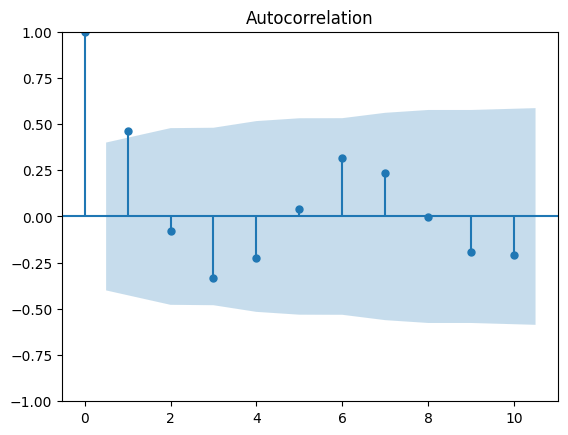

In [7]:
count = monthly_orders['distinct_orders']

sm.graphics.tsa.plot_acf(count, lags=10)
plt.show()

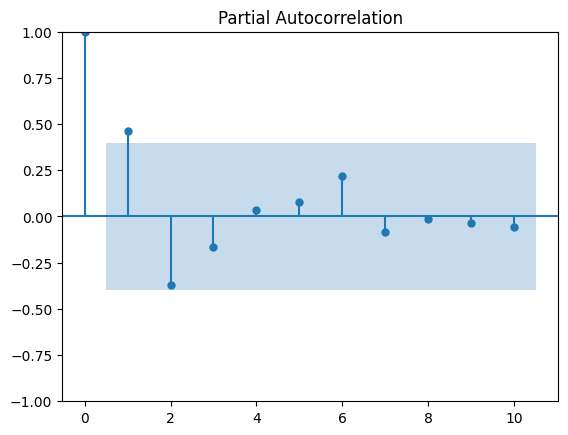

In [8]:
sm.graphics.tsa.plot_pacf(count, lags=10)
plt.show()

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

def calculate_monthly_orders_with_sarima(data):
    """
    Groups transactional data by month to calculate the number of unique orders.
    Applies SARIMA model for forecasting and evaluates its performance.
    Forecasts for the next five months and the next two months.
    """
    # Step 1: Preprocessing
    data['order_date'] = pd.to_datetime(data['order_date'], format='%d.%m.%Y')
    data['year_month'] = data['order_date'].dt.to_period('M')
    monthly_orders = (
        data.groupby('year_month')['Customer Order Code']
        .nunique()
        .reset_index(name='distinct_orders')
    )

    # Prepare data for SARIMA
    monthly_orders['year_month'] = pd.to_datetime(monthly_orders['year_month'].astype(str))

    # Split data into training and testing sets
    # Splitting the data into train and test (up to 2011-06 as train)
    train_size = int(len(monthly_orders)) - 5
    train_data = monthly_orders.iloc[:train_size]
    test_data = monthly_orders.iloc[train_size:]


    # Step 2: Fit SARIMA model
    sarima_model = SARIMAX(train_data['distinct_orders'],
                           order=(1, 0, 1),
                           seasonal_order=(2, 2, 2, 12))
    sarima_result = sarima_model.fit(disp=False)

    # Step 3: Forecast for the test set (existing data)
    forecast_test = sarima_result.forecast(steps=len(test_data))

    # Step 4: Forecast for future months
    future_forecast_2_months = sarima_result.forecast(steps=2)

    return forecast_test, future_forecast_2_months

In [10]:
calculate_monthly_orders_with_sarima(data)

/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


(19    54.000009
 20    64.500011
 21    16.500003
 22     1.500000
 23     1.500000
 Name: predicted_mean, dtype: float64,
 19    54.000009
 20    64.500011
 Name: predicted_mean, dtype: float64)

Q2

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def classify_and_evaluate_product_demand(data):
    """
    Prepares data for a classification model by encoding features, trains a logistic regression model,
    and evaluates it. Forecasts demand for the next specified number of months.
    """
    # Add seasonality based on the order date
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'

    # Preprocessing
    data['order_date'] = pd.to_datetime(data['order_date'], format='%d.%m.%Y')
    data['Season'] = data['order_date'].dt.month.apply(get_season)
    data = data.sort_values(by='order_date')  # Sort data by time

    # Extract the last 5 months
    last_date = data['order_date'].max()
    last_5_months = last_date - pd.DateOffset(months=5)
    test_data = data[data['order_date'] > last_5_months]
    train_data = data[data['order_date'] <= last_5_months]

    # Encode categorical variables
    encoded_train_data = pd.get_dummies(train_data, columns=['Season', 'Customer Country Code', 'Curr', 'Route', 'order_type','Customer Order Code'], drop_first=True)
    encoded_test_data = pd.get_dummies(test_data, columns=['Season', 'Customer Country Code', 'Curr', 'Route', 'order_type','Customer Order Code'], drop_first=True)

    # Align columns in train and test sets
    X_train = encoded_train_data.drop(columns=['Product Code', 'year_month', 'order_date', 'requested_delivery_date', 'Description'])
    y_train = encoded_train_data['Product Code']

    X_test = encoded_test_data.drop(columns=['Product Code', 'year_month', 'order_date', 'requested_delivery_date', 'Description'])
    y_test = encoded_test_data['Product Code']

    # Ensure alignment of columns (fix potential mismatch)
    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    # Train a logistic regression model
    logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=40)
    logistic_model.fit(X_train, y_train)

    # Make predictions
    y_pred_logistic = logistic_model.predict(X_test)

    # Forecast demand for the next `months`
    future_forecast_demand = np.unique(y_pred_logistic)

    return future_forecast_demand

In [12]:
classify_and_evaluate_product_demand(data)

/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array(['L10705400', 'L12134400', 'L12134600', 'L12135800'], dtype=object)

Q3

In [13]:
import pandas as pd
import numpy as np

def simulate_quantity_demand(data, n_months=5):
    """
    Recalculates 25th and 75th percentiles for each product and simulates demand for the next n months.
    :param data: Pandas DataFrame with columns 'Product Code' and 'items'.
    :param n_months: Number of months to simulate demand for.
    :return: DataFrame with simulated demand for each product.
    """
    # Recalculate percentiles for each product
    # Ensure the 'items' column is numeric
    data['items'] = pd.to_numeric(data['items'], errors='coerce')
    data = data[data['Product Code'].isin(classify_and_evaluate_product_demand(data))]

    
    # Drop rows with NaN in the 'items' column after conversion
    data = data.dropna(subset=['items'])
    # Add seasonality based on the order date
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'
    # Preprocessing
    data['order_date'] = pd.to_datetime(data['order_date'], format='%d.%m.%Y')
    data['Season'] = data['order_date'].dt.month.apply(get_season)
    data = data.sort_values(by='order_date')  # Sort data by time

    # Extract the last 5 months
    last_date = data['order_date'].max()
    last_5_months = last_date - pd.DateOffset(months=5)
    test_data = data[data['order_date'] > last_5_months]
    train_data = data[data['order_date'] <= last_5_months]


    # Group by 'Product Code' and calculate the quantiles
    quantity_bounds = train_data.groupby('Product Code')['items'].quantile([0.25, 0.5, 0.75]).unstack().reset_index()
    # Rename the columns for clarity

    
    quantity_bounds.columns = ['Product Code', '25th Percentile','50th Percentile', '75th Percentile']


    # Simulate demand for the next n_months
    simulated_demand = []

    for _, row in quantity_bounds.iterrows():
        mean_quantity = row['50th Percentile']
        std_dev_quantity = (row['75th Percentile'] - row['25th Percentile']) / 6  # Assuming normal distribution
        product_demand = np.random.normal(mean_quantity, std_dev_quantity, n_months).clip(0)  # Ensure no negative values
        simulated_demand.append(product_demand)

    # Create a DataFrame for the simulated demand
    simulated_demand_data = pd.DataFrame(
        simulated_demand,
        columns=[f"Month {i+1}" for i in range(n_months)],
        index=quantity_bounds['Product Code']
    ).reset_index().round()

    # Rename columns for clarity
    simulated_demand_data.rename(columns={'index': 'Product Code'}, inplace=True)

    return simulated_demand_data

In [14]:
simulate_quantity_demand(data)

/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Product Code,Month 1,Month 2,Month 3,Month 4,Month 5
0,L10705400,6.0,8.0,6.0,7.0,9.0
1,L12134400,7.0,6.0,5.0,5.0,5.0
2,L12134600,6.0,5.0,5.0,4.0,4.0
3,L12135800,7.0,7.0,7.0,7.0,7.0


Q4

In [15]:
# Define the function to calculate lead time
def calculate_and_simulate_lead_time(data, n_months = 5):
    # Filter data for the specified product codes
    data = data[data['Product Code'].isin(classify_and_evaluate_product_demand(data))] 
       
    data['order_date'] = pd.to_datetime(data['order_date'], format='%d.%m.%Y')
    data = data.sort_values(by='order_date')  # Sort data by time
    
    # Step 2: Convert date columns and calculate lead time in months
    data['order_date'] = pd.to_datetime(data['order_date'], format='%d.%m.%Y')
    data['requested_delivery_date'] = pd.to_datetime(data['requested_delivery_date'], format='%d.%m.%Y')
    data['lead_time'] = (data['requested_delivery_date'] - data['order_date']).dt.days / 30
   
    # Extract the last 5 months
    last_date = data['order_date'].max()
    last_5_months = last_date - pd.DateOffset(months=5)
    test_data = data[data['order_date'] > last_5_months]
    train_data = data[data['order_date'] <= last_5_months]


    # Group by 'Product Code' and calculate the quantiles
    leadtime_bounds = train_data.groupby('Product Code')['lead_time'].quantile([0.01, 0.5, 0.99]).unstack().reset_index()
    # Rename the columns for clarity

    
    leadtime_bounds.columns = ['Product Code', '1st Percentile','50th Percentile', '99th Percentile']


    # Simulate demand for the next n_months
    simulated_leadtime = []

    for _, row in leadtime_bounds.iterrows():
        mean = row['50th Percentile']
        std = (row['99th Percentile'] - row['1st Percentile']) / 1.41
        product_leadtime = np.random.uniform(row['1st Percentile'], row['99th Percentile'], n_months).clip(0)  # Ensure no negative values
        simulated_leadtime.append(product_leadtime)

    # Create a DataFrame for the simulated demand
    simulated_leadtime_data = pd.DataFrame(
        simulated_leadtime,
        columns=[f"Month {i+1}" for i in range(n_months)],
        index=leadtime_bounds['Product Code']
    ).reset_index()

    # Rename columns for clarity
    simulated_leadtime_data.rename(columns={'index': 'Product Code'}, inplace=True)

    return simulated_leadtime_data

In [16]:
calculate_and_simulate_lead_time(data)

/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/hj/50ynckj97xq7d49_2_s66f100000gn/T/ipykernel_78689/3315416440.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

,Product Code,Month 1,Month 2,Month 3,Month 4,Month 5
0,L10705400,8.400863,5.532041,5.490566,6.231003,6.795557
1,L12134400,5.545604,6.182125,9.443099,7.984776,5.952663
2,L12134600,7.515090,6.163162,8.066409,8.870430,7.110042
3,L12135800,6.609974,5.634284,9.698596,7.543908,7.435643


consolidate function

In [17]:
def monte_carlo_simulation(data, n_months=5, n_simulations=100):
    """
    Consolidated Monte Carlo simulation that integrates:
    1. Monthly order forecasting using SARIMA.
    2. Product demand classification.
    3. Quantity demand simulation.
    4. Lead time simulation.

    Parameters:
    - data: Original DataFrame containing order and demand data.
    - n_months: Number of months for forecasting and simulations.
    - n_simulations: Number of lead-time samples per month for simulation.

    Returns:
    - Consolidated simulation results from all steps.
    """
    # Step 1: Forecast monthly orders with SARIMA
    future_forecast_orders = calculate_monthly_orders_with_sarima(data)

    # Step 2: Classify product demand
    future_demand_forecast = classify_and_evaluate_product_demand(data)

    # Step 3: Simulate quantity demand
    simulated_quantity = simulate_quantity_demand(data)

    # Step 4: Calculate and simulate lead time
    simulated_lead_times = calculate_and_simulate_lead_time(data)

    # Consolidate results into a dictionary
    results = {
        "Future Orders Forecast (SARIMA)": future_forecast_orders,
        "Future Product Demand Forecast (Logistic Regression)": future_demand_forecast,
        "Simulated Quantities": simulated_quantity,
        "Simulated Lead Times": simulated_lead_times.iloc[-5:],
    }
    
    return results

In [18]:
monte_carlo_simulation(data)

/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/

{'Future Orders Forecast (SARIMA)': (19    54.000009
  20    64.500011
  21    16.500003
  22     1.500000
  23     1.500000
  Name: predicted_mean, dtype: float64,
  19    54.000009
  20    64.500011
  Name: predicted_mean, dtype: float64),
 'Future Product Demand Forecast (Logistic Regression)': array(['L10705400', 'L12134400', 'L12134600', 'L12135800'], dtype=object),
 'Simulated Quantities':   Product Code  Month 1  Month 2  Month 3  Month 4  Month 5
 0    L10705400      8.0      6.0      7.0      9.0      4.0
 1    L12134400      6.0      5.0      7.0      5.0      5.0
 2    L12134600      6.0      7.0      7.0      3.0      4.0
 3    L12135800      7.0      7.0      7.0      7.0      7.0,
 'Simulated Lead Times':   Product Code   Month 1   Month 2   Month 3    Month 4    Month 5
 0    L10705400  6.724113  7.336874  6.102917   8.024515   8.410347
 1    L12134400  6.657057  6.275633  4.738340  10.032755  11.282873
 2    L12134600  7.260920  9.711875  6.146532  10.066147   8.500075


In [19]:
# Create the Simulated Quantities DataFrame
simulated_quantities_updated = pd.DataFrame({
    'Product Code': ['L10705400', 'L12134400', 'L12134600', 'L12135800'],
    '2011-07': [7, 5, 4, 7],
    '2011-08': [8, 5, 6, 7],
    '2011-09': [8, 6, 5, 7],
    '2011-10': [3, 3, 6, 7],
    '2011-11': [8, 4, 6, 7]
})


In [20]:
simulated_quantities_updated

,Product Code,2011-07,2011-08,2011-09,2011-10,2011-11
0,L10705400,7,8,8,3,8
1,L12134400,5,5,6,3,4
2,L12134600,4,6,5,6,6
3,L12135800,7,7,7,7,7


In [21]:
# Filter the data for the specified product codes and the time range (2011-07 to 2011-11)
# Assuming data has a column 'date' with datetime format, and 'quantity' for product quantities

# Convert the order_date column to datetime if necessary
data['order_date'] = pd.to_datetime(data['order_date'], format='%d.%m.%Y', errors='coerce')

# Filter for the relevant product codes and date range
filtered_data = data[
    (data['Product Code'].isin(['L10705400', 'L12134400', 'L12134600', 'L12135800'])) &
    (data['order_date'] >= '2011-07-01') &
    (data['order_date'] <= '2011-11-30')
]

# Group by product code and month to summarize quantities
filtered_data['month'] = filtered_data['order_date'].dt.to_period('M')
summary_table = filtered_data.groupby(['Product Code', 'month']).agg({'items': 'sum'}).unstack(fill_value=0)

# Rename the columns to match the format (e.g., 2011-07, 2011-08, ...)
summary_table.columns = summary_table.columns.droplevel(0)
summary_table.columns = [col.strftime('%Y-%m') for col in summary_table.columns]
summary_table = summary_table.reset_index()

summary_table

/var/folders/hj/50ynckj97xq7d49_2_s66f100000gn/T/ipykernel_78689/1042182402.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['month'] = filtered_data['order_date'].dt.to_period('M')


,Product Code,2011-07,2011-08,2011-09,2011-11
0,L12134400,53,77,22,0
1,L12134600,17,34,5,2
2,L12135800,7,5,0,0


In [22]:
start_date = '2011-07-01'
end_date = '2011-11-30'
product_codes = ['L10705400', 'L12134400', 'L12134600', 'L12135800']


filtered_data = data[
    (data['order_date'] >= start_date) & 
    (data['order_date'] <= end_date) & 
    (data['Product Code'].isin(product_codes))
]


filtered_data['Month'] = filtered_data['order_date'].dt.to_period('M')


pivot_table = filtered_data.pivot_table(
    index='Product Code', columns='Month', values='items', aggfunc='sum', fill_value=0
)


pivot_table.columns = pivot_table.columns.astype(str)


print(pivot_table)

Month         2011-07  2011-08  2011-09  2011-11
Product Code                                    
L12134400          53       77       22        0
L12134600          17       34        5        2
L12135800           7        5        0        0


/var/folders/hj/50ynckj97xq7d49_2_s66f100000gn/T/ipykernel_78689/1895917120.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Month'] = filtered_data['order_date'].dt.to_period('M')


In [1]:
import pandas as pd

# Define the actual and predicted data manually
actual_data = pd.DataFrame({
    'Product Code': ['L12134400', 'L12134600', 'L12135800'],
    '2011-07': [53, 17, 7],
    '2011-08': [77, 34, 5],
    '2011-09': [22, 5, 0],
    '2011-10': [0, 0, 0],
    '2011-11': [0, 2, 0]
}).set_index('Product Code')

predicted_data = pd.DataFrame({
    'Product Code': ['L10705400', 'L12134400', 'L12134600', 'L12135800'],
    '2011-07': [7, 5, 4, 7],
    '2011-08': [8, 5, 6, 7],
    '2011-09': [8, 6, 5, 7],
    '2011-10': [3, 6, 3, 7],
    '2011-11': [8, 4, 6, 7]
}).set_index('Product Code')

# Keep only matching Product Codes in both datasets
common_codes = actual_data.index.intersection(predicted_data.index)
actual_data = actual_data.loc[common_codes]
predicted_data = predicted_data.loc[common_codes]

# Calculate MAPE
mape = (abs(actual_data - predicted_data) / actual_data).replace([float('inf'), -float('inf')], 0).mean().mean() * 100
mape

43.70822222542533